In [2]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import uniform, norm, cauchy

# Lecture 6: Monte Carlo, importance sampling, particle filtry

## Importance sampling

Rejection sampling compensates the fact that is simulates samples from the target density using a different (proposal) density by the *accept-reject* approach. This can be seen as ineffective, because many samples are discarded. Fortunately, there is an alternative method - **importance sampling** - that compensates the fact via assigning **weights** to **all** samples.

We will denote by $f(x)$ our (complicated) target density and by $g(x)$ the proposal density. Obviously,

$$
\int f(x) dx = \int g(x) \underbrace{\frac{f(x)}{g(x)}}_{= w(x)} dx = \int g(x) w(x) dx.
$$

The condition is $g(x) > 0$ where $f(x) > 0$.

Moreover, we can generalize this, for instance, for the mean of a function $h(x)$ under $f(x)$ it holds

$$
\mathbb{E}_f[h(x)] = \int h(x) f(x) dx =  \int h(x) \frac{f(x)}{g(x)}g(x) dx = \int h(x) w(x) g(x) dx = \mathbb{E}_g[w(x)h(x)], \qquad g(x) > 0.
$$

Again, we need $g(x) > 0$ where $h(x)f(x) \ne 0$.

For random samples $x_1, \ldots, x_N \sim g$ it holds that if $N\to\infty$,

$$
\begin{aligned}
\frac{1}{N} \sum_{i=1}^N w(x_i)h(x_i) 
&\to \mathbb{E}_g[w(x)h(x)] \\
&\to \mathbb{E}_f[h(x)].
\end{aligned}
$$

That is, the estimate of the expected value is a weighted arithmetic average of samples,

$$
\hat{\mu} = \frac{1}{N} \sum_{i=1}^N w(x_i)h(x_i).
$$

As $w(x_i)$ need not sum to 1, we often perform normalization for practical purposes,
$$
W(x_i) = \frac{w(x_i)}{\sum_{i=1}^{N} w(x_i)}.
$$

leading to

$$
\hat{\mu} = \sum_{i=1}^N W(x_i)h(x_i).
$$

This estimate is biased, but may have a lower variance. Moreover, in the Bayesian theory, it has a very appealing property: it does not depend on the normalization constant (why?), whose calculation we prefer to avoid (why?) :)


### Importance sampling algorithm

The whole algorithms is about calculation of weights :)

   1. Simulate $N$ samples from the proposal density: $x_i \sim g(x)$.
   2. Calculate the values of $f(x_i)$.
   3. Calculate the values of $g(x_i)$.
   4. Calculate weights $w(x_i) = \frac{f(x_i)}{g(x_i)}$.
   5. Normalize: $W(x_i) = w(x_i)/\sum w(x_i)$ or $W(x_i)=w(x_i)/N$.
   
For instance, $\hat{\mu} = \sum w(x_i) x_i$.

### Example

Let us try to calculate the mean value of the Student's $t_3$ distribution centered in 1:

Estimated mean with N:  1.14545662855
Estimated mean with normalized w:  1.08564380346


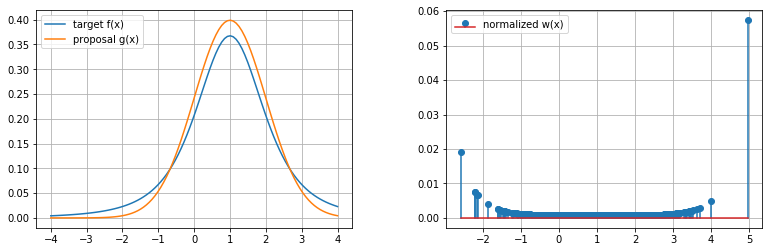

In [7]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import norm, uniform, t

nsamples = 1000    ### Number of samples
proposal_loc = 1  ### Mean of normal proposal
proposal_std = 1  ### St. deviation of normal proposal

# Target - t distribution
def target_pdf(x):
    return t.pdf(x, df=3, loc=1)

samples_x = norm.rvs(loc=proposal_loc, scale=proposal_std, size=nsamples)

fx = target_pdf(samples_x)
gx = norm.pdf(samples_x, loc=proposal_loc, scale=proposal_std)

weights = fx/gx
weights_normalized = weights/weights.sum()

mean = np.mean(samples_x * weights)
mean_normalized = np.sum(samples_x * weights_normalized)
print('Estimated mean with N: ', mean)
print('Estimated mean with normalized w: ', mean_normalized)

plt.figure(figsize=(13,4))
plt.subplot(121)
x = np.linspace(-4, 4, 100)
plt.plot(x, target_pdf(x), label='target f(x)')
plt.plot(x, norm.pdf(x, loc=proposal_loc, scale=proposal_std), label='proposal g(x)')
plt.legend()
plt.subplot(122)
plt.stem(samples_x, weights_normalized, label='normalized w(x)')
plt.legend()
plt.show()

### Empirical distribution

If we have samples $\{x_i\}_{i=1}^N = \{x_1, \ldots, x_N\}$ over a set $E$, we talk about the empirical distribution

$$
\eta^N(x) = \frac{1}{N} \sum_{i=1}^N \delta_{x_i}(x).
$$

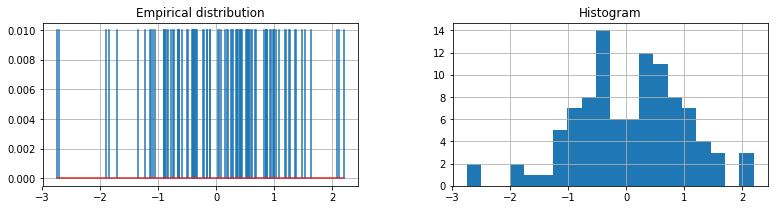

In [3]:
x = np.random.normal(size=100)
plt.figure(figsize=(13,3))
plt.subplot(121)
plt.title('Empirical distribution')
plt.stem(x, np.ones_like(x)/x.size, markerfmt=' ')
plt.subplot(122)
plt.title('Histogram')
plt.hist(x, bins=20)
plt.show()

Alternatively, if $x_i$ are assigned with weights $w_i$, i.e., we have $\{x_i, w_i\}_{i=1}^N$, we may talk about the empirical distribution of the form

$$
\tilde{\eta}^N(x) = \frac{\sum_{i=1}^N w_i \delta_{x_i}(x)}{\sum_{i=1}^N w_i},
$$

where we may normalize

$$
W_i = \frac{w_i}{\sum_{i=1}^N w_i}.
$$

Then, it is possible to write, e.g.,

$$
\int h(x)g(x)dx \approx \int h(x) g^N(x) dx,
$$

where $g^N(x)$ is the empirical distribution consisting of samples $x_i \sim g(x)$.

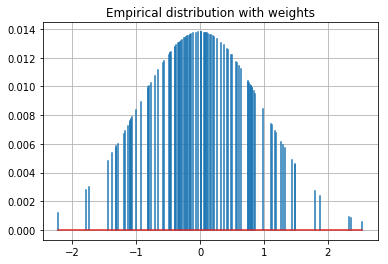

In [4]:
x = norm.rvs(size=100)
wx = norm.pdf(x)
wx /= wx.sum()
plt.stem(x, wx, markerfmt=' ')
plt.title('Empirical distribution with weights')
plt.show()

## Sequential Importance Sampling (SIS)

Let us now study how to perform IS sequentially. We see that

$$
\begin{aligned}
\int h(x_1, x_2) \pi(x_1, x_2) dx_1 dx_2
&= \int h(x_1, x_2) \frac{\pi(x_1, x_2)}{q(x_1, x_2)} q(x_1, x_2) dx_1 dx_2 \\
&= \int h(x_1, x_2) \frac{\pi(x_1, x_2)}{q(x_2|x_1) q(x_1)} q(x_1)q(x_2|x_1) dx_1 dx_2 \\
&= \int h(x_1, x_2) \underbrace{\frac{\pi(x_1, x_2)}{q(x_2|x_1) \pi(x_1)}}_{\widetilde{w}_2} \underbrace{\frac{\pi(x_1)}{q(x_1)}}_{w_1} q(x_1)q(x_2|x_1) dx_1 dx_2. \\
\end{aligned}
$$

That is, we can start from some $x_1$ with the weight $w_1$, then obtain $x_2$ using some density - model - $q(x_2|x_1)$ and only *increment* the weight by $\widetilde{w}_2$. This is very useful, as it allows start from a point and then only update the weights by the adopted model.

We will exploit this on the state-space models. Recall, that they have the form

$$
\begin{aligned}
x_t &\sim f_t(x_t|x_{t-1}), \\
y_t &\sim g_t(y_t|x_t),
\end{aligned}
$$

where $x_t$ is the (non-observable) state, $f_t(x_t|x_{t-1})$ is the state evolution model density, $y_t$ are measurements with the model density $g_t(y_t|x_t)$. We already know, that under linearity, the Kalman filter provides an optimal filtering solution. If there are mild nonlinearities, we may try the extended Kalman filter. And if there are severe nonlinearities, the **importance sampling** algorithms are very popular.

Similarly to the Kalman filter (and all other Bayesian estimators) we start with a convenient prior distribution. However, we do not use it as a function, but **simulate samples** in order to obtain an empirical distribution represented by  $\{x_{1:t-1}^{(i)}, w_{t-1}^{(i)}\}_{i=1}^N$,

$$
\pi(x_{1:t-1}|y_{1:t-1}) = \sum_{i=1}^N w_{t-1}^{(i)} \delta_{x_{1:t-1}^{(i)}}(x_{1:t-1}).
$$

As well as in the case of the Kalman filter, the basic sequential importance sampling (SIS) filter runs in two steps: prediction and correction (update).

### Prediction
Prediction provides the transition from $x_{t-1}$ to $x_t$ according to the model. Hence we use the prior distribution and multiply it by the model

$$
\pi(x_{1:t}|y_{1:t-1}) = \pi(x_{1:t-1}|y_{1:t-1}) \cdot f_t(x_t|x_{t-1}).
$$

In terms of the SIS filter, it means to use the samples in place of the conditioning state

$$
x_t^{(i)} \sim f_t(x_t|x_{t-1}^{(i)}).
$$

This results in a new empirical distribution,

$$
\pi(x_{1:t}|y_{1:t-1}) = \sum_{i=1}^N w_{t-1}^{(i)} \delta_{x_{1:t}^{(i)}}(x_{1:t}).
$$

### Update
Update applies the Bayes' theorem - it uses newly acquired measurements,

$$
\begin{aligned}
\pi(x_{1:t}|y_{1:t})
&\propto \pi(x_{1:t}|y_{1:t-1}) \cdot g_t(y_t|x_t) \\
&\approx \frac{\sum_{i=1}^N w_{t-1}^{(i)} \delta_{x_{1:t}^{(i)}}(x_{1:t}) \cdot g(y_t|x_t^{(i)})}{\sum_{i=1}^N w_{t-1}^{(i)}(x_{1:t}) \cdot g(y_t|x_t^{(i)})} \\
&\propto \sum_{i=1}^N w_t^{(i)} \delta_{x_{1:t}^{(i)}}(x_{1:t}).
\end{aligned}
$$

Hence

$$
w_t^{(i)} = w_{t-1}^{(i)} g(y_t|x_t^{(i)}),
$$

followed by normalization

$$
w_t^{(i)} \leftarrow \frac{w_t^{(i)}}{\sum_{j=1}^N w_t^{(j)}}.
$$

### Remark

The SIS filter with a *resampling* step (described below) leads to the *bootstrap particle filter*. However, we could use adaptive proposals $q(x_t|x_{t-1}, y_t)$ updating the weights

$$
w_t^{(i)} \propto w_{t-1}^{(i)} \frac{g(y_t|x_t^{(i)}) f(x_{t}|x_{t-1})}{q(x_{t}|x_{t-1}, y_t)}.
$$

However, using

$$
q(x_{t}|x_{t-1}, y_t) \equiv f(x_t|x_{t-1})
$$

leads to a very simple (and potentially less effective) filter.

### Algorithm of the SIS filter
   1. Simulate $x_0^{(i)}$ from a convenient proposal $\pi(x_0)$ a přiřadíme jim rovnoměrné váhy $w_0^{(i)} = 1/N$.
   2. For $t=1,2,\ldots$:
       - Prediction: sample new $x_t^{(i)}$ from pdf $f_t(x_t|x_{t-1}^{(i)})$.
       - Update: Calculate weights $w_t^{(i)} = w_{t-1}^{(i)} g(y_t|x_t^{(i)})$ and normalize $w_t^{(i)} \leftarrow w_t^{(i)}/\sum_j w_t^{(j)}$.
       - Estimate $\mathbb{E}[x_t|\cdot] = w_{t}^{(i)} x_t^{(i)}$.

### Example

For simplicity, let us assume a linear state-space model

$$
\begin{align}
x_t &= 0.9 x_{t-1} + 0.7 + w_t \\
y_t &= 0.5 x_t + v_t
\end{align}
$$

where $x_1$ = 1, and

$$
w_t \sim \mathcal{N}(0, 0.2^2), \qquad v_t \sim \mathcal{N}(0, 0.2^2).
$$

As the proposal we use $\mathcal{N}(0, 1)$.

A very simple (non-optimal) code follows:

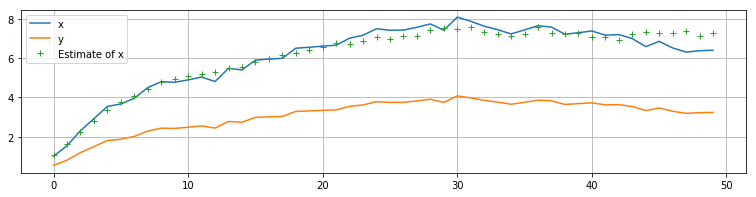

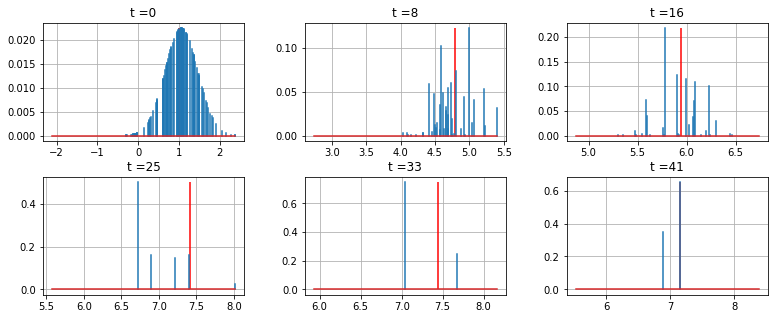

In [9]:
nsamples = 100    ### Number of samples
proposal_loc = 0  ### Mean of normal proposal
proposal_std = 1  ### St. deviation of normal proposal

ndat = 50         ### number of observations
xstd = .2         ### noise std on x
ystd = .2         ### noise std on y

def prediction(xold):
    loc = .9 * xold + .7
    xnew = norm.rvs(loc=loc, scale=xstd)
    return xnew

def update(y, x, weights):
    loc = .5 * x
    weights *= norm.pdf(y, loc=loc, scale=ystd)
    weights /= weights.sum()
    return weights

x = np.zeros(ndat)
x[0] = 1
y = np.zeros(ndat)

# Data simulation
for t in range(1, ndat):
    x[t] = .9 * x[t-1] + .7
    x[t] += norm.rvs(scale=xstd)
y = .5 * x + norm.rvs(scale=ystd)

# Filter initialization
samples_x = norm.rvs(loc=proposal_loc, scale=proposal_std, size=nsamples)
weights = np.ones(nsamples)/nsamples

# Logs
est_log = np.zeros(ndat)
weights_log = np.zeros((ndat, nsamples))
samples_log = np.zeros((ndat, nsamples))
for t, yt in enumerate(y):
    # Prediction
    samples_x = prediction(samples_x)

    # Update
    weights = update(yt, samples_x, weights)
    
    # Estimate & log
    estimate = np.sum(samples_x * weights)
    est_log[t] = estimate
    weights_log[t] = weights.copy()
    samples_log[t] = samples_x.copy()

plt.figure(figsize=(13, 3))
plt.plot(x, label='x')
plt.plot(y, label='y')
plt.plot(est_log, '+', label='Estimate of x')
plt.legend()

plt.figure(figsize=(13, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    row = i * ndat // 6
    plt.stem(samples_log[row], weights_log[row], markerfmt=' ')
    plt.vlines(x[row], 0, weights_log[row].max(), color='red')
    plt.title('t ={0}'.format(row))

The plots demonstrate several interesting facts. First, the evolution and estimate of $x_t$ and the evolution of $y_t$. The six smaller plots show the evolution of weights of samples. Recall, that their number is `nsamples`, but the filter degenerates to just a few effective samples! We will see how to treat this.

What more could be improved? First, the calculation of weights is potentially numerically problematic - the incremental weights are very close to 0 and recall that the computers work with finite precision arithmetics. Hence it would be more safe to calculate in logarithms.

## Sequential importance resampling (SIR) - particle filter

The SIS filter degeneracy was clearly demonstrated above. In the limit, we would obtain a single sample with weight 1 and other would have weight 0. That is, the filter is prone to colapse.

The most popular solution lies in **resampling**. It consists in selecting "better" samples (with higher weights) and their replication. On the other side, samples with lower weights are with a high probability discarded.ahozeny. 

The basic resampling method chooses $N$ samples (with replacement) from $\{x_{t-1}^{(i)}, w_t^{(i)}\}_{i=1}^N$, and the probability of a sample $x_{t-1}^{(i)}$ to be chosen is proportional to its weight $w_{t-1}^{(i)}$. That is, samples with higer weights are more likely to be chosen several times. The samples are subsequently spread using the state evolution equation. The weights of the samples after resamping are uniformly $1/N$.

### Bootstrap particle filter
   1. Sample $x_0^{(i)}$ from a convenient proposal $\pi(x_0)$ and assign them uniform weights $w_0^{(i)} = 1/N$.
   2. For $t=1,2,\ldots$:
       - Resampling: choose $\tilde{x}_{t-1}^{(i)}\sim \sum_{i=1}^N w_{t-1}^{(i)} x_{t-1}^{(i)}$ proportionally to their weights $w_{t-1}^{(i)}$, set weights $1/N$.
       - Prediction: sample $x_t^{(i)}$ from $f_t(x_t|\tilde x_{t-1}^{(i)})$.
       - Update: calculate $w_t^{(i)} = w_{t-1}^{(i)} g(y_t|x_t^{(i)})$ and normalize $w_t^{(i)} \leftarrow w_t^{(i)}/\sum_j w_t^{(j)}$.
       - Estimate: $\mathbb{E}[x_t|\cdot] = w_{t}^{(i)} x_t^{(i)}$.

The only difference to the SIS filter is resampling (here *multinomial*). We may choose more effective resampling algorithms (e.g., stratified resampling), resample each time or after several time steps etc.

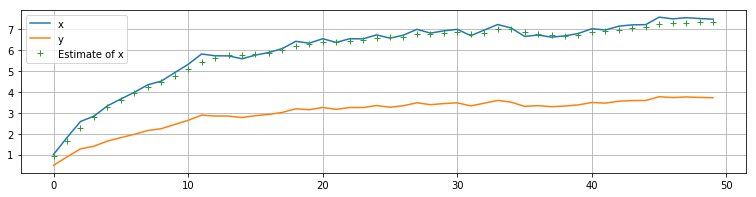

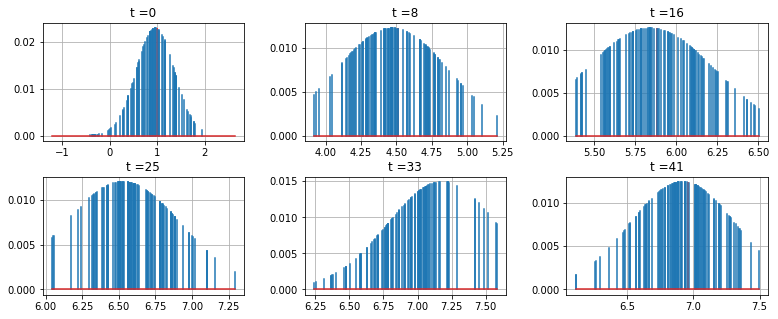

In [6]:
nsamples = 100    ### Number of samples
proposal_loc = 0  ### Mean of normal proposal
proposal_std = 1  ### St. deviation of normal proposal

ndat = 50         ### number of observations
xstd = .2         ### noise std on x
ystd = .2         ### noise std on y

def prediction(xold):
    loc = .9 * xold + .7
    xnew = norm.rvs(loc=loc, scale=xstd)
    return xnew

def update(y, x, weights):
    loc = .5 * x
    weights *= norm.pdf(y, loc=loc, scale=ystd)
    weights /= weights.sum()
    return weights

def resample(x, weights):
    xnew = np.random.choice(x, replace=True, p=weights, size=weights.size)
    weights = np.ones_like(weights)/weights.size
    return [xnew, weights]

x = np.zeros(ndat)
x[0] = 1
y = np.zeros(ndat)

# Data simulation
for t in range(1, ndat):
    x[t] = .9 * x[t-1] + .7
    x[t] += norm.rvs(scale=xstd)
y = .5 * x + norm.rvs(scale=ystd)

# Filter initialization
samples_x = norm.rvs(loc=proposal_loc, scale=proposal_std, size=nsamples)
weights = np.ones(nsamples)/nsamples

# Logs
est_log = np.zeros(ndat)
weights_log = np.zeros((ndat, nsamples))
samples_log = np.zeros((ndat, nsamples))
for t, yt in enumerate(y):
    # Resampling
    samples_x, weights = resample(samples_x, weights)
    
    # Prediction
    samples_x = prediction(samples_x)

    # Update
    weights = update(yt, samples_x, weights)
    
    # Estimate & log
    estimate = np.sum(samples_x * weights)
    est_log[t] = estimate
    weights_log[t] = weights.copy()
    samples_log[t] = samples_x.copy()

plt.figure(figsize=(13, 3))
plt.plot(x, label='x')
plt.plot(y, label='y')
plt.plot(est_log, '+', label='Estimate of x')
plt.legend()

plt.figure(figsize=(13, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    row = i * ndat // 6
    plt.stem(samples_log[row], weights_log[row], markerfmt=' ')
    plt.vlines(x[row], 0, weights_log[row].max(), color='red')
    plt.title('t ={0}'.format(row))

## Other particle filtration algorithms

The topic of particle filters is very rich. For instance, we may focus on
   - marginalized particle filters - if there is a linear part of the state-space model, we may calculate it with Kalman filter, and use particle filters for the nonlinear parts only.
   - Auxiliary particle filter - just another PF.
   - Approximate Bayesian filter - if the measurement model $g_t$ is not a pdf or it is too complicated to be calculated, but it is still possible to simulate from it.
   - and many many other topics...